In [ ]:
from pathlib import Path
import numpy as np


### Current vs. resonant energy analysis
Load in the resonant energy results from the `station_energies.py` script

In [8]:
from pathlib import Path
from collections import defaultdict
resonant_energy_folder =  Path("../../../_outputs_/_spec_data_/_spec_data_28_36_/spectrogram_data/")
resonant_energy_folder = Path("results/UP37_46_predictions/resonant_energy_arrays")
# Dictionary to store files by station
files_by_station = defaultdict(list)
resonant_energy_array_files = list(Path(resonant_energy_folder).glob("*.h5"))
# Populate the dictionary
for path in resonant_energy_array_files:
    filename = path.name
    station = filename.split('_')[0]  # Extract station (e.g., UP42)
    files_by_station[station].append(path.name)

# Sort the lists of paths for each station alphanumerically
for station in files_by_station:
    files_by_station[station].sort(key=lambda x: x)
    print(station, len(files_by_station[station]))

UP41 37424
UP45 37448
UP42 37427
UP39 37416
UP43 37437
UP40 37421
UP46 37452
UP37 37413
UP38 37413


In [9]:
import re

def extract_timestamps(filename):
    """Extracts start and end timestamps from a given filename."""
    match = re.search(r'(\d{4}\.\d{2}\.\d{2}-\d{6})-(\d{4}\.\d{2}\.\d{2}-\d{6})', filename)
    if match:
        return match.groups()
    return None, None

def check_continuity(file_list):
    """Checks if the file list is continuous without gaps."""
    for i in range(len(file_list) - 1):
        _, end_time = extract_timestamps(file_list[i])
        start_time, _ = extract_timestamps(file_list[i + 1])
        if end_time != start_time:
            print(f"Gap detected between {file_list[i]} and {file_list[i + 1]}")
            return False

    print("The file list is continuous.")
    return True

# Example list
for key in files_by_station:
    print(key)
    file_list = files_by_station[key]
    check_continuity(file_list)

import pandas as pd
import re

def extract_timestamps_from_files(files):
    """Extract timestamps from filenames and return a sorted datetime index."""
    timestamps = []
    
    for file in files:
        match = re.search(r'(\d{4}\.\d{2}\.\d{2}-\d{6})-(\d{4}\.\d{2}\.\d{2}-\d{6})', file)
        if match:
            start_time = pd.to_datetime(match.group(1), format='%Y.%m.%d-%H%M%S')
            timestamps.append(start_time)
    
    return sorted(set(timestamps))  # Ensure unique and sorted timestamps

def build_station_dfs(station_energies, files_by_station):
    """Create a merged DataFrame of all stations with aligned timestamps."""
    all_dfs = []
    
    for station, energy_values in station_energies.items():
        if station not in files_by_station:
            continue  # Skip stations without file data
        energy_values = np.array(energy_values)
        timestamps = extract_timestamps_from_files(files_by_station[station])
        
        # Ensure number of timestamps matches energy values
        if len(timestamps) != len(energy_values):
            print(f"Warning: Mismatch in timestamps and values for {station}")
            continue

        # Create DataFrame for the station
        df = pd.DataFrame({'timestamp': timestamps, station: energy_values})
        df.set_index('timestamp', inplace=True)
        all_dfs.append(df)

    # Merge all station DataFrames, aligning timestamps
    final_df = pd.concat(all_dfs, axis=1, join='outer')

    return final_df


UP41
The file list is continuous.
UP45
The file list is continuous.
UP42
The file list is continuous.
UP39
The file list is continuous.
UP43
The file list is continuous.
UP40
The file list is continuous.
UP46
The file list is continuous.
UP37
The file list is continuous.
UP38
The file list is continuous.


In [10]:
import pandas as pd
import numpy as np
from scipy.signal import correlate, savgol_filter

def smooth_series(series, method='moving_avg', window=3, polyorder=2):
    """Smooths a time series using the chosen method."""
    series = series.dropna()  # Drop NaNs before smoothing
    
    if method == 'moving_avg':
        return series.rolling(window=window, min_periods=1).mean()
    
    elif method == 'exp_moving_avg':
        return series.ewm(span=window, adjust=False).mean()
    
    elif method == 'savitzky_golay':
        if len(series) < window:  # Ensure enough points for smoothing
            return series
        return pd.Series(savgol_filter(series, window_length=window, polyorder=polyorder), index=series.index)
    
    else:
        raise ValueError("Invalid smoothing method. Choose 'moving_avg', 'exp_moving_avg', or 'savitzky_golay'.")

def cross_correlation(series1, series2, max_lag=10, smooth=False, method='moving_avg', window=3):
    """Computes cross-correlation and finds the best time lag, with optional smoothing."""
    
    # Drop NaNs before computing correlation
    valid_idx = series1.notna() & series2.notna()
    series1, series2 = series1[valid_idx], series2[valid_idx]

    if len(series1) < 2:
        return None, None  # Not enough data to compute correlation

    # Apply smoothing if enabled
    if smooth:
        series1 = smooth_series(series1, method=method, window=window)
        series2 = smooth_series(series2, method=method, window=window)

    # Compute correlation for different lags
    lags = np.arange(-max_lag, max_lag + 1)
    corr_values = [series1.corr(series2.shift(lag)) for lag in lags]

    # Find the best lag (max absolute correlation)
    best_lag = lags[np.nanargmax(np.abs(corr_values))]
    best_corr = corr_values[np.nanargmax(np.abs(corr_values))]

    return best_lag, best_corr, corr_values

def compute_optimal_lags(df, max_lag=10, smooth=False, method='moving_avg', window=3):
    """Computes optimal lags between all pairs of stations with optional smoothing."""
    stations = df.columns
    results = {}

    for i in range(len(stations)):
        for j in range(i + 1, len(stations)):
            station1, station2 = stations[i], stations[j]
            best_lag, best_corr, corr_values = cross_correlation(
                df[station1], df[station2], max_lag, smooth, method, window
            )

            if best_lag is not None:
                results[(station1, station2)] = {'best_lag': best_lag, 'correlation': best_corr}

    return results



In [11]:
import pickle
if not Path('station_energies.pkl').exists():
        
    with open('station_energies.pkl', 'wb') as f:
        pickle.dump(station_energies, f)
else:
    with open('station_energies.pkl', 'rb') as f:
        station_energies = pickle.load(f)
df = build_station_dfs(station_energies, files_by_station)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, windows


from sklearn.preprocessing import RobustScaler

from scipy.signal import butter, filtfilt

import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, windows

def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Design a bandpass Butterworth filter.
    :param lowcut: Low cutoff frequency in Hz.
    :param highcut: High cutoff frequency in Hz.
    :param fs: Sampling frequency in Hz.
    :param order: Order of the filter.
    :return: Filter coefficients (b, a).
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low_normal_cutoff = lowcut / nyquist
    high_normal_cutoff = highcut / nyquist
    b, a = butter(order, [low_normal_cutoff, high_normal_cutoff], btype='bandpass', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass Butterworth filter to a time series data.
    :param data: The time series data (Pandas Series).
    :param lowcut: Low cutoff frequency (Hz).
    :param highcut: High cutoff frequency (Hz).
    :param fs: Sampling frequency (Hz).
    :param order: Order of the filter.
    :return: The filtered time series.
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

def apply_taper(series, taper_percentage=0.01):
    """
    Apply a tapering window to the time series (0.01% taper).
    :param series: The time series data (Pandas Series).
    :param taper_percentage: The percentage of the data to taper at each end (default 0.01%).
    :return: The tapered time series.
    """
    # window = windows.hann(len(series))  # Hanning window
    window = windows.tukey(len(series), taper_percentage)
    return series * window

def preprocess_and_filter(df, cutoff_hours=6, sampling_interval='15T', taper_percentage=0.05):
    """
    Preprocess the time series by removing NaNs, applying a low-pass filter, and tapering.
    :param df: The DataFrame with time series data.
    :param cutoff_hours: The cutoff period for low-pass filtering in hours (default 6).
    :param sampling_interval: The sampling interval (e.g., '15T' for 15 minutes).
    :param taper_percentage: The tapering percentage to apply (default 0.01%).
    :return: The preprocessed and filtered time series DataFrame.
    """
    # Remove NaNs (interpolate or drop)
    df = df.interpolate(method='time').dropna(axis=0)  # Interpolate missing values

    # Calculate the sampling frequency (in Hz)
    sampling_freq = pd.Timedelta(sampling_interval).total_seconds()
    fs = 1 / sampling_freq  # Convert to Hz

    # Convert the cutoff period (6 hours) to frequency in Hz
    cutoff = 1 / (cutoff_hours * 3600 * 2)  # 6 hours converted to Hz (period = 6 hours)
    cutoff_high = 1 / (cutoff_hours * 3600 * 2.2)  # 6 hours converted to Hz (period = 6 hours)

    old_index = df.index
    # pad with zeros by percentage
    df = df.apply(lambda x: np.pad(x, (int(len(old_index)*taper_percentage/2), int(len(old_index)*taper_percentage/2)), mode='constant', constant_values=0))
    df_filtered = df.apply(lambda x: apply_taper(x, taper_percentage))  # Apply tapering
    df_filtered = df_filtered.apply(lambda x: bandpass_filter(x, cutoff_high, cutoff, fs))  # Apply low-pass filter

    # Remove the padded zeros
    df_filtered = df_filtered.apply(lambda x: x[int(len(old_index)*taper_percentage/2): -int(len(old_index)*taper_percentage/2)])
    # set old index
    df_filtered.index = old_index

    return df_filtered
def remove_outliers_zscore(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    return series[abs(z_scores) <= threshold]


def robust_scale(series):
    scaler = RobustScaler()
    return pd.Series(scaler.fit_transform(series.values.reshape(-1, 1)).flatten(), index=series.index)

def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

def smooth_series(series, method='moving_avg', window=3, polyorder=2):
    """Smooths a time series using the chosen method."""
    series = series.dropna()  # Drop NaNs before smoothing
    
    if method == 'moving_avg':
        return series.rolling(window=window, min_periods=1).mean()
    
    elif method == 'exp_moving_avg':
        return series.ewm(span=window, adjust=False).mean()
    
    elif method == 'savitzky_golay':
        if len(series) < window:  # Ensure enough points for smoothing
            return series
        return pd.Series(savgol_filter(series, window_length=window, polyorder=polyorder), index=series.index)
    
    else:
        raise ValueError("Invalid smoothing method. Choose 'moving_avg', 'exp_moving_avg', or 'savitzky_golay'.")

def cross_correlation(series1, series2, max_lag=10, smooth=False, method='moving_avg', window=3):
    """Computes cross-correlation and returns correlation values for different lags."""
    
    # Drop NaNs before computing correlation
    valid_idx = series1.notna() & series2.notna()
    series1, series2 = series1[valid_idx], series2[valid_idx]

    if len(series1) < 2:
        return None, None  # Not enough data to compute correlation

    # Apply smoothing if enabled
    # Compute correlation for different lags
    lags = np.arange(-max_lag, max_lag + 1)
    corr_values = [series1.corr(series2.shift(lag)) for lag in lags]
    # Find the best lag (max absolute correlation)
    best_lag = lags[np.nanargmax(corr_values)]
    # print(corr_values, best_lag)
    best_corr = corr_values[np.nanargmax(corr_values)]

    return best_lag, best_corr, corr_values

def compute_optimal_lags(df, max_lag=10, smooth=False, method='moving_avg', window=3):
    """Computes optimal lags between all pairs of stations (without time filtering)."""
    stations = df.columns
    # df = df.apply(smooth_series, method=method, window=window) if smooth else df
    # remove column-wise mean
     # Robust scaling for each station

    # Remove outliers using Z-score method
    # df_no_outliers = df_smoothed.apply(remove_outliers_zscore, threshold=3)
    
    # Detrend the series if needed
    results = {}

    for i in range(len(stations)):
        for j in range(i + 1, len(stations)):
            station1, station2 = stations[i], stations[j]
            best_lag, best_corr, corr_values = cross_correlation(df[station1], df[station2], max_lag, False, method, window)

            if best_lag is not None:
                results[(station1, station2)] = {
                    'best_lag': best_lag,
                    'best_corr': best_corr, 
                    'corr_series':corr_values,
                    'series1': df[station1],
                    'series2': df[station2],
                }

    return results

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_shifted_time_series(results, station1, station2, start_time=None, end_time=None, max_lag=None):
    """Plots time series for two stations, with one series shifted by the optimal lag and an inlay of the correlation series."""
    
    # Ensure the requested station pair exists
    if (station1, station2) not in results and (station2, station1) not in results:
        print(f"Error: No correlation data found for {station1} and {station2}.")
        return
    
    # Retrieve the result in either order
    result = results.get((station1, station2), results.get((station2, station1)))

    # Extract data
    best_lag = result['best_lag']
    series1 = result['series1']
    series2 = result['series2'].shift(best_lag)  # Shift series2 by the optimal lag

    # Apply time filtering only for plotting
    if start_time and end_time:
        valid_idx = (series1.index >= start_time) & (series1.index <= end_time)
        valid_idx_2 = (series2.index >= start_time) & (series2.index <= end_time)
        series1, series2 = series1[valid_idx], series2[valid_idx_2]

    # Create the main plot
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.plot(series1.index, series1, label=f"{station1}", color='b')
    ax.plot(series2.index, series2, label=f"{station2} (shifted by {best_lag})", color='r', linestyle='--')

    ax.set_xlabel("Time")
    ax.set_ylabel("Energy")
    ax.set_title(f"Time Series Comparison: {station1} vs {station2} (Shifted): Corr {result['best_corr']:.2f}")
    ax.legend()
    ax.grid()

    # Add inlay of the correlation series
    if max_lag is not None:
        corr_series = result['corr_series']
        
        # Create inset axes in the top-left corner of the main plot
        ax_inlay = inset_axes(ax, width="20%", height="20%", loc="upper left")
        ax_inlay.plot(np.arange(-max_lag, max_lag+1), corr_series, label=f"Correlation Series")
        ax_inlay.axvline(x=best_lag, color='r', linestyle='--', label=f"Best Lag = {best_lag}")
        
        ax_inlay.set_xlabel("Lag")
        ax_inlay.set_ylabel("Correlation")
        ax_inlay.legend()
        ax_inlay.grid()

    # Show the plot
    plt.show()

def plot_corr_series(results, station1, station2, max_lag):
    """Plots the correlation series for two stations."""
    
    # Ensure the requested station pair exists
    if (station1, station2) not in results and (station2, station1) not in results:
        print(f"Error: No correlation data found for {station1} and {station2}.")
        return
    
    # Retrieve the result in either order
    result = results.get((station1, station2), results.get((station2, station1)))

    # Extract data
    corr_series = result['corr_series']
    best_lag = result['best_lag']

    # Plot the correlation series
    plt.figure(figsize=(18, 5))
    plt.plot(np.arange(-max_lag, max_lag+1), corr_series, label=f"Correlation Series")
    plt.axvline(x=best_lag, color='r', linestyle='--', label=f"Best Lag = {best_lag}")

    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.title(f"Cross-Correlation Series: {station1} vs {station2}")
    plt.legend()
    plt.grid()
    plt.show()


# save with pickel
# df_smoothed = df - df.mean()
# # subtract columnwise moving average
# moving_avg = df_smoothed.apply(smooth_series, method='moving_avg', window=20)
# df_smoothed = df_smoothed - moving_avg
df_smoothed = preprocess_and_filter(df)
# df_smoothed = df_smoothed.apply(robust_scale) 

# # Example Usage:
# # Compute lags on full dataset
# start_time = "2022-01-14 00:00:00"
# end_time = "2022-03-14 00:00:00"
# optimal_lags = compute_optimal_lags(df_smoothed.loc[start_time:end_time], max_lag=5, smooth=False, method='moving_avg', window=10)

# # Plot a specific station pair with time filtering only in visualization
# plot_shifted_time_series(optimal_lags, station1="UP38", station2="UP42", 
#                          start_time=start_time, end_time=end_time, max_lag=5)

/tmp/ipykernel_268890/3262252295.py:67: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  sampling_freq = pd.Timedelta(sampling_interval).total_seconds()


In [13]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Haversine formula to compute distance between two points on the Earth (lat, lon in decimal degrees)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance in kilometers
    distance_km = R * c
    
    # Convert distance to meters
    return distance_km * 1000

# Function to compute pairwise time lag
def compute_time_lags(stations, lat_lon, wave_speed=200):
    # Create a dictionary to hold time lags
    time_lags = {}

    # Loop over each pair of stations
    for i, (station1, lat1, lon1) in enumerate(zip(stations, lat_lon[:, 0], lat_lon[:, 1])):
        for j, (station2, lat2, lon2) in enumerate(zip(stations, lat_lon[:, 0], lat_lon[:, 1])):
            if i >= j:  # Skip pairs already calculated (symmetric)
                continue
            
            # Calculate the Haversine distance
            distance = haversine(lat1, lon1, lat2, lon2)
            
            # Calculate the expected time lag (distance / wave speed)
            time_lag = distance / wave_speed
            
            # Store the result
            time_lags[(station1, station2)] = time_lag

    return time_lags

# Load the station data from the file as a NumPy array
stations_file = 'data/UPFLOW_STATIONS'

# Read the data from the file
data = np.loadtxt(stations_file, dtype='str')  # Read all columns as string
stations = data[:, 0]  # Extract station names
lat_lon = data[:, 2:4].astype(float)  # Extract lat, lon as float

# Compute the pairwise time lags
time_lags = compute_time_lags(stations, lat_lon)



In [14]:
from obspy import UTCDateTime,read_inventory
def try_to_get_orientation(inv, sta_id, time):
    try:
        return inv.get_orientation(sta_id, time)
    except:
        return None
inv = read_inventory("/data/UPFLOW/_input_/dataless.8J.UPFLOW.converted_plusFTrotations.xml")
station_azimuths = {}
for station in stations:

    for i in range(45):
        if inv[0][i]._code == station:

            up_lat = inv[0][i].latitude
            up_lon = inv[0][i].longitude
            up_net = inv[0]._code
            up_nam = inv[0][i]._code 
            for up_cha in ['CH1', 'HH1', 'BH1', 'CN1']:
                sta_id = f"{up_net}.{up_nam}..{up_cha}"
                orient = try_to_get_orientation(inv, sta_id, UTCDateTime("2022-01-01"))
                if orient:
                    break
            if not orient:
                print(station)
                continue

    station_azimuths[station] = orient['azimuth']


/tmp/ipykernel_268890/1506803379.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / (xf * 60 * 60)


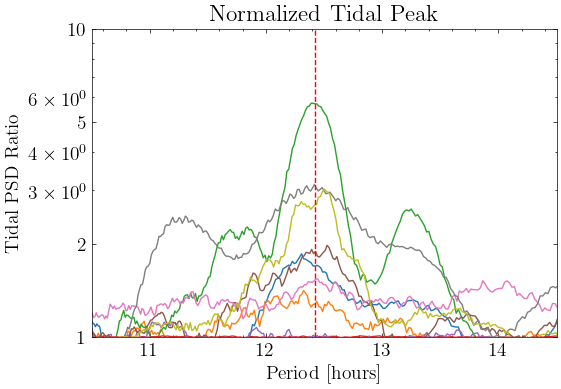

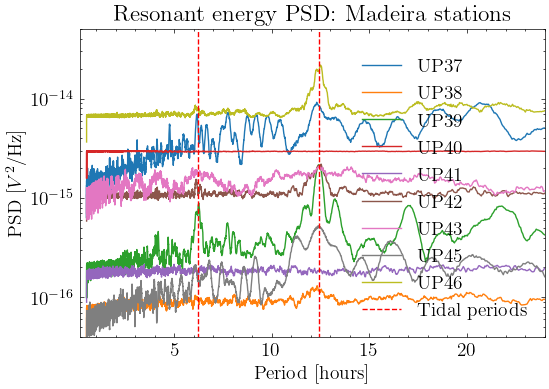

<Figure size 350x262.5 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import windows
# set fontsize
plt.rcParams.update({'font.size': 14})

def plot_resonant_energy_psd(station_energies, savefig = None):
    fs = 1 / (15 * 60)  # Sampling frequency
    T = 1 / fs

    # Create two separate figures
    fig_main, ax_main = plt.subplots(figsize=(6, 4))  # Main plot axis
    fig_inset, ax_inset = plt.subplots(figsize=(6, 4))  # Inset plot axis

    # Define tidal peak region
    tidal_peak = 12.42  # hours
    window_half_width = 2.5  # hours
    tidal_range = (tidal_peak - window_half_width, tidal_peak + window_half_width)


    ax_main.set_prop_cycle(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])
    ax_inset.set_prop_cycle(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])

    for station, resonant_energy_timeseries in sorted(station_energies.items()):
        # Demean
        resonant_energy_timeseries -= np.mean(resonant_energy_timeseries)
    
        # Taper
        taper_percentage = 0.02
        window = windows.tukey(len(resonant_energy_timeseries), taper_percentage)
        resonant_energy_timeseries *= window

        # FFT
        N = len(resonant_energy_timeseries)
        yf = fft(resonant_energy_timeseries)
        xf = fftfreq(N, T)[:N // 2]

        # Convert frequencies to periods in hours
        periods = 1 / (xf * 60 * 60)
        psd = 2.0 / N * np.abs(yf[0:N // 2])
        psd = np.convolve(psd, np.ones(24) / 24, mode='same')  # Smooth PSD

        # Compute baseline (mean PSD outside tidal region)
        non_tidal_indices = np.where(
            ((periods < tidal_range[0]) & (periods > tidal_range[0] - window_half_width)) |
            ((periods > tidal_range[1]) & (periods < tidal_range[1] + window_half_width))
        )[0]
    
        psd_baseline = np.mean(psd[non_tidal_indices])

        # Compute ratio
        psd_ratio = psd / psd_baseline

        # Main plot (original PSD)
        ax_main.semilogy(periods, psd, label=station)

        # Inset plot (normalized PSD)
        ax_inset.semilogy(periods, psd_ratio, label=station)

    # Formatting main plot
    ax_main.set_xlim([0.15, 24])
    ax_main.set_ylim([40.e-18, 5.e-14])
    ax_main.vlines([6.2, 12.42], 1e-17, 5e-14, colors='r', linestyles='dashed', label='Tidal periods')
    ax_main.legend(loc='lower right')
    ax_main.set_title('Resonant energy PSD: Madeira stations')
    ax_main.set_xlabel('Period [hours]')
    ax_main.set_ylabel('PSD [$V^2$/Hz]')

    # Formatting inset plot
    ax_inset.set_xlim([10.5, 14.5])  # Focus around the tidal peak
    ax_inset.set_ylim([1, 10])  # Dynamic range

    # Manually set y-ticks and labels
    ax_inset.set_yticks([1, 2, 5, 10])
    ax_inset.set_yticklabels([1, 2, 5, 10])

    ax_inset.set_title('Normalized Tidal Peak')
    ax_inset.set_xlabel('Period [hours]')
    ax_inset.set_ylabel('Tidal PSD Ratio')
    ax_inset.vlines([12.42], 1, 10, colors='r', linestyles='dashed', label='Tidal periods')

    # Explicitly control tick parameters to prevent overwriting from the style

    # Show the two separate plots
    if savefig:
        fig_main.savefig(savefig + '_main.svg', dpi=200, transparent=True)
        fig_inset.savefig(savefig + '_inset.svg', dpi=200, transparent=True)
    plt.figure(fig_main.number)
    plt.show()

    plt.figure(fig_inset.number)
    plt.show()


# Use std-colors color cycle
with plt.style.context(['science', 'rainbow']):
    plot_resonant_energy_psd(station_energies, savefig='data/psd_resonant_energy')


In [27]:
import xarray as xr
import netCDF4
current_data_path ="/data/UPFLOW/projects/iReverb/reverb/data/surface_current.nc"
def load_current_data(current_data_path):
    ds = xr.open_dataset(current_data_path, engine='netcdf4')
    return ds
current_data = load_current_data(current_data_path)
# combine u0 and v0 into magnitude (speed)
current_data['speed'] = np.sqrt(current_data['uo'] ** 2 + current_data['vo'] ** 2)
speed_timeseries = {}
use_speed = True
for station, (lat, lon) in zip(stations, lat_lon):
    # Extract the speed at the station's latitude and longitude
    speed_time = current_data['speed'].sel(latitude=lat, longitude=lon, method='nearest')
    speed_timeseries[station] = speed_time.to_pandas()

In [31]:
import xarray as xr
def load_current_data(current_data_path):
    ds = xr.open_dataset(current_data_path)
    return ds
def prep_data(current_data_path, station_azimuths, angle_offset = -90, speed_weighting = 0.2):
    current_data = load_current_data(current_data_path)
    # combine u0 and v0 into magnitude (speed)
    current_data['speed'] = np.sqrt(current_data['ubar'] ** 2 + current_data['vbar'] ** 2)
    current_data['angle'] = np.arctan2(current_data['vbar'], current_data['ubar'])
    # create 1D time series of the speed at each UPFLOW station
    speed_timeseries = {}
    use_speed = True
    for station, (lat, lon) in zip(stations, lat_lon):
        # Extract the speed at the station's latitude and longitude
        if use_speed:
            # speed_time = current_data['speed'].sel(latitude=lat, longitude=lon, method='nearest')
            # angle = current_data['angle'].sel(latitude=lat, longitude=lon, method='nearest')
            station_orientation = np.deg2rad(station_azimuths[station]  + angle_offset)
            # take dot product using the orientation of the station and angle
            speed_time = current_data['speed'].sel(latitude=lat, longitude=lon, method='nearest')
            ub = current_data['ubar'].sel(latitude=lat, longitude=lon, method='nearest')
            vb = current_data['vbar'].sel(latitude=lat, longitude=lon, method='nearest')
            speed_time = (
                speed_weighting*np.sqrt(ub**2 + vb**2) +  
                ( ub * np.sin(station_orientation)) + (vb * np.cos(station_orientation))
            )
        else:
            tide_heights = current_data['zos'].sel(latitude=lat, longitude=lon, method='nearest')
            # get the absolute gradient of the tide heights
            tide_heights = tide_heights.diff('zos')
            # compute abs
            speed_time = np.abs(tide_heights)

        speed_timeseries[station] = speed_time.to_pandas()
    return speed_timeseries

def average_hourly_resampled(df):
    df_smooth = df.rolling(window=5, center=True).mean()
    return df_smooth.resample('H').asfreq()  # Keeps only hourly timestamps

def plot_station_comparison(merged_df, station, start_time, end_time):
    """Plot energy and current speed time series for a given station."""
    
    # Select data for the given station and time range
    station_data = merged_df[[station]].loc[start_time:end_time]
    
    if station_data.isna().all().all():
        print(f"No data available for {station} in the given time range.")
        return

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Energy", color="tab:blue")
    ax1.plot(station_data.index, station_data[station].iloc[:, 0], color="tab:blue", label="Energy")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Current Speed", color="tab:red")
    ax2.plot(station_data.index, station_data[station].iloc[:, 1], color="tab:red", linestyle="dashed", label="Current Speed")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.tight_layout()
    plt.title(f"Energy vs. Current Speed at {station}")
    plt.show()

def compute_optimal_lag_single_station(merged_df, station, start_time, end_time, max_lag=10):
    """Computes the optimal lag between energy and speed for a single station over a given time range."""
    
    # Ensure the station exists
    if station not in merged_df.columns:
        print(f"Error: Missing data for station {station}. Ensure both energy and speed exist.")
        return None

    # Extract time-filtered data
    station_data = merged_df[station].loc[start_time:end_time]
    if station_data.dropna().empty:
        print(f"No data available for {station} in the given time range.")
        return None

    # Compute cross-correlation
    best_lag, best_corr, corr_values = cross_correlation(
        station_data.iloc[:, 0], station_data.iloc[:, 1], max_lag
    )

    return {
        "station": station,
        "best_lag": best_lag,
        "best_corr": best_corr,
        "corr_series": corr_values,
        "energy_series": station_data.iloc[:, 0],
        "speed_series": station_data.iloc[:, 1],
    }

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_shifted_time_series_single_station(results, start_time=None, end_time=None, max_lag=10):
    """Plots energy and current speed for a single station, shifting speed by optimal lag, with an inlay of the correlation series."""
    
    if results is None:
        print("No results to plot.")
        return

    # Extract data
    station = results["station"]
    best_lag = results["best_lag"]
    energy_series = results["energy_series"]
    speed_series = results["speed_series"].shift(best_lag)  # Shift speed by optimal lag

    # Apply time filtering only for plotting
    if start_time and end_time:
        energy_series = energy_series.loc[start_time:end_time]
        speed_series = speed_series.loc[start_time:end_time]

    # Create the main plot
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(energy_series.index, energy_series, label="Energy", color="b")
    ax.plot(speed_series.index, speed_series, label=f"Current Speed", color="r", linestyle="--")

    ax.set_xlabel("Time")
    ax.set_ylabel("Normalised Values")
    ax.set_title(f"{station}: $R^2={results['best_corr']:.2f}$")
    ax.legend(facecolor='white', edgecolor='black')
    ax.grid()

    # Add inlay of the correlation series
    if max_lag is not None:
        corr_series = results["corr_series"]
        
        # Create inset axes in the top-left corner of the main plot
        ax_inlay = inset_axes(ax, width="20%", height="20%", loc="upper left")
        ax_inlay.plot(np.arange(-max_lag, max_lag+1), corr_series, label="Correlation Series")
        ax_inlay.axvline(x=best_lag, color="r", linestyle="--", label=f"Best Lag = {best_lag}")

        ax_inlay.set_xlabel("Lag")
        ax_inlay.set_ylabel("Correlation")
        ax_inlay.legend()
        ax_inlay.grid()

    # Show the plot
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colorbar as cbar
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_best_fit(merged_df, stations, grid_size=(3, 3), figsave = None):
    """
    Creates a multi-axis figure (e.g., 3x3) with scatter plots of current speed vs. energy for each station.
    Colors scatter points by timestamp and includes a line of best fit with R² value.

    :param merged_df: DataFrame containing energy and speed data for stations.
    :param stations: List of station names to plot.
    :param grid_size: Tuple specifying the number of rows and columns for subplots.
    """
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust figure size
    axes = axes.flatten()  # Flatten in case of 2D array

    # Convert the full datetime index to Matplotlib numeric format (NO int64 conversion!)
    all_times = mdates.date2num(merged_df.index)

    norm = plt.Normalize(all_times.min(), all_times.max())  # Normalize timestamps
    cmap = plt.cm.plasma  # Use a perceptually uniform colormap

    for i, station in enumerate(stations):
        if i >= len(axes):  
            break  # Prevent exceeding subplot count

        ax = axes[i]

        # Extract data
        energy = merged_df[station].iloc[:, 0].dropna()
        speed = merged_df[station].iloc[:, 1].dropna()
        valid_idx = energy.index.intersection(speed.index)  # Align indices
        energy, speed = energy.loc[valid_idx], speed.loc[valid_idx]

        if energy.empty or speed.empty:
            ax.set_title(f"{station} (No Data)")
            ax.axis("off")
            continue

        # Convert datetime index to Matplotlib format (NO astype needed!)
        timestamps_num = mdates.date2num(valid_idx)

        # Scatter plot with color mapping
        sc = ax.scatter(x=speed, y=energy, c=timestamps_num, cmap=cmap, norm=norm, alpha=0.2)

        # Fit linear model
        X = speed.values.reshape(-1, 1)
        y = energy.values
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        # Plot best fit line
        # ax.plot(speed, y_pred, color="red", label=f"Best Fit (R²={r2:.2f})")

        ax.set_xlabel("Projected current velocity")
        ax.set_ylabel("Resonant energy")
        ax.set_title(f"Tidal signal: {station}")
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    # Create a separate colorbar
    cbar_fig, cbar_ax = plt.subplots(figsize=(1, 8))
    # cbar_fig.subplots_adjust(bottom=0.5)

    # ScalarMappable with corrected datetime values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array to avoid errors

    # Create colorbar
    cbar = cbar_fig.colorbar(sm, cax=cbar_ax, label='Date')

    # Set proper date formatting for the colorbar
    cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))  # Year-month format
    cbar.ax.yaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-spacing of ticks

    if figsave:
        fig.savefig(figsave, dpi=200, transparent=True)
        cbar_fig.savefig(figsave.replace('.png', '_colorbar.svg'), dpi=200, transparent=True)
        plt.close()
    else:

        plt.show()

# for station in ['UP38', 'UP42', 'UP46']:
#     plot_station_comparison(merged_df, station=station, start_time="2022-03-01", end_time="2022-03-07")


    # Compute the optimal lag for a single station
# start_time = "2021-12-14 00:00:00"
# end_time = "2022-02-01 00:00:00"
# # start_time = "2021-10-14 00:00:00"
# # end_time = "2021-12-01 00:00:00"
# station = "UP46"
# smoothed_df = df.apply(min_max_scale)
# smoothed_df = preprocess_and_filter(smoothed_df, sampling_interval='1h', taper_percentage=0.05)
# smoothed_df = smoothed_df.apply(min_max_scale)

# results = compute_optimal_lag_single_station(smoothed_df, station, start_time, end_time, max_lag=0)

# # Plot the results
# plot_shifted_time_series_single_station(results, start_time, end_time, max_lag=0)



In [32]:
manual_station_azimuths = {
    "UP38": 168,
    "UP39": 332,
    "UP40": 345,
    "UP41":91,
    "UP42": 72,
    "UP43": 81,
    "UP44": 319,
    "UP45": 115,
    "UP46": 195,

}

In [33]:
all_station_azimuths = {**station_azimuths, **manual_station_azimuths}
all_station_azimuths["UP46"]

195

In [34]:
import numpy as np
import pandas as pd
import scienceplots
current_data_path ="/data/UPFLOW/projects/iReverb/reverb/data/tide_and_barotropic_v.nc"
# iterate azimuth offsets by 22.5 degrees from -180 to 0
azimuth_offsets = np.arange(0, 135, 22.5)
azimuth_offsets = [67.5]
plt.rcParams.update({'font.size': 14})
# azimuth_offsets = np.linspace(-180, 0, 9)#]#[-135]
speed_weightings = [0.2]
for azimuth_offset in azimuth_offsets:
    for speed_weighting in speed_weightings:
        print(azimuth_offset ,speed_weighting,)
        speed_timeseries = prep_data(current_data_path, all_station_azimuths,azimuth_offset,speed_weighting)
        hourly_energies_df = average_hourly_resampled(df)
        # clip to remove negative values
        hourly_energies_df = hourly_energies_df.clip(lower=0).apply(lambda x: np.log(x + 1.e-18))
        hourly_energies_df = hourly_energies_df# / hourly_energies_df.rolling('7D').apply(lambda x: x.abs().mean())
        # join with df of station energies
        station_speeds = pd.DataFrame(speed_timeseries)
        station_speeds.index = pd.to_datetime(station_speeds.index)
        # select only the stations (i.e. columns) that appear in hourly_energies_df
        station_speeds = station_speeds[hourly_energies_df.columns]
        smoothed_df = pd.concat([hourly_energies_df, station_speeds], axis=1, join='outer')
        # smoothed_df = smoothed_df / smoothed_df.rolling('7D').apply(lambda x: x.abs().mean())
        # smoothed_df = merged_df.apply(lambda x: np.log(x + 1.e-18))#
        # remove outlits
        # smoothed_df = smoothed_df.apply(remove_outliers_zscore)

        smoothed_df = preprocess_and_filter(smoothed_df, sampling_interval='1h', taper_percentage=0.1)
        smoothed_df = smoothed_df.apply(min_max_scale)


        # smoothed_df = smoothed_df.apply(min_max_scale)
        # slice to cut off begining and end
        # smoothed_df = smoothed_df.apply(lambda x: x[1000:-2000])
        stations_to_plot = ['UP42','UP46']
        with plt.style.context('science'):
            plot_scatter_with_best_fit(smoothed_df, stations_to_plot, grid_size=(1, 2), figsave=f"data/scatter_{azimuth_offset}.png")



67.5 0.2


/tmp/ipykernel_268890/1794194109.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df_smooth.resample('H').asfreq()  # Keeps only hourly timestamps
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
start_time = "2021-12-31 00:00:00"
end_time = "2022-01-14 00:00:00"
start_time = "2021-11-01 00:00:00"
end_time = "2021-11-28 00:00:00"
# start_time = "2022-04-01 00:00:00"
# end_time = "2022-04-28 00:00:00"
station = "UP46"

results = compute_optimal_lag_single_station(smoothed_df, station, start_time, end_time, max_lag=0)
plt.rcParams.update({'font.size': 18})

# Plot the results
with plt.style.context('science'):
    results = compute_optimal_lag_single_station(smoothed_df, "UP46", start_time, end_time, max_lag=0)
    plot_shifted_time_series_single_station(results, start_time, end_time, max_lag=None)
with plt.style.context('science'):
    results = compute_optimal_lag_single_station(smoothed_df, "UP42", start_time, end_time, max_lag=0)
    plot_shifted_time_series_single_station(results, start_time, end_time, max_lag=None)